In [8]:
import pandas as pd
import numpy as np
import torch
import keras
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import MultilabelF1Score
from keras.preprocessing import image
from matplotlib import pyplot as plt

import cv2
import os
from nltk import wordpunct_tokenize
import re
import warnings
warnings.filterwarnings('ignore')

# Data

In [9]:
# You need extract file ml1m.zip to folder ml1m before run code

users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='ISO-8859-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='ISO-8859-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_train.index.name = 'ID'
movies_test['genre'] = movies_test.genre.str.split('|')
movies_test.index.name = 'ID'

users.age = users.age.astype('int')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('int')
ratings.userid = ratings.userid.astype('int')

In [10]:
with open('ml1m/content/dataset/genres.txt', 'r') as f:
    genre_all = f.readlines()
genres = [genre.strip() for genre in genre_all]
genres

['Crime',
 'Thriller',
 'Fantasy',
 'Horror',
 'Sci-Fi',
 'Comedy',
 'Documentary',
 'Adventure',
 'Film-Noir',
 'Animation',
 'Romance',
 'Drama',
 'Western',
 'Musical',
 'Action',
 'Mystery',
 'War',
 "Children's"]

In [11]:
def preprocess(df, path='ml1m/content/dataset/ml1m-images', genres=genres) -> pd.DataFrame:
    df['img_path'] = df.apply(lambda x: os.path.join(path, str(x.name) + '.jpg'), axis=1)

    # multi-hot encoding
    for genre in genres:
        df[genre] = df.genre.apply(lambda x: 1 if genre in x else 0)
    df.drop(columns=['genre'], inplace=True)

    # Remove movies without images
    df = df[df.img_path.apply(lambda x: os.path.exists(x))]

    return df

In [12]:
trainset = preprocess(movies_train)
testset = preprocess(movies_test)

In [13]:
def vectorize(df) -> (list, list):
    x = []
    for i in tqdm(range(len(df))):
        img = image.load_img(df.iloc[i].img_path, target_size=(224, 224, 3))
        img = image.img_to_array(img)
        img = img / 255
        x.append(img)
    y = df[genres].values
    return x, y

In [14]:
x_train, y_train = vectorize(trainset)
x_test, y_test = vectorize(testset)

100%|██████████| 654/654 [00:03<00:00, 188.63it/s]


## Model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
conv_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = True

model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(18, activation='softmax'))

In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model._name = 'Poro'

Epoch 1/10


74/74 [==============================] - 551s 7s/step - loss: 0.3080 - accuracy: 0.2157 - val_loss: 0.2827 - val_accuracy: 0.2529
Epoch 2/10
74/74 [==============================] - 518s 7s/step - loss: 0.2815 - accuracy: 0.2661 - val_loss: 0.2659 - val_accuracy: 0.3410
Epoch 3/10
74/74 [==============================] - 514s 7s/step - loss: 0.2737 - accuracy: 0.2755 - val_loss: 0.2625 - val_accuracy: 0.3295
Epoch 4/10
74/74 [==============================] - 494s 7s/step - loss: 0.2652 - accuracy: 0.2973 - val_loss: 0.2848 - val_accuracy: 0.2529
Epoch 5/10
74/74 [==============================] - 489s 7s/step - loss: 0.2551 - accuracy: 0.3276 - val_loss: 0.2710 - val_accuracy: 0.3027
Epoch 6/10
74/74 [==============================] - 535s 7s/step - loss: 0.2489 - accuracy: 0.3217 - val_loss: 0.2565 - val_accuracy: 0.3831
Epoch 7/10
74/74 [==============================] - 533s 7s/step - loss: 0.2388 - accuracy: 0.3533 - val_loss: 0.2721 - val_accuracy: 0.2989
Epoch 8/10


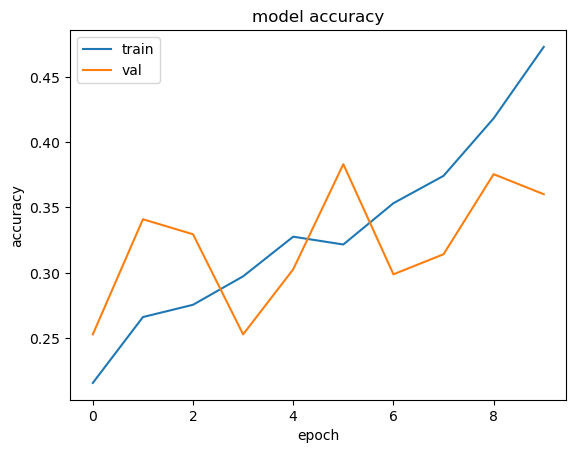

In [18]:
history = model.fit(np.array(x_train), np.array(y_train), epochs=10, batch_size=32, validation_split=0.1, workers=4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

## Loss

In [20]:
# Calculate Multi-label F1 score, threshold = 0.5, average = 'macro'
y_pred = model.predict(np.array(x_test))
y_pred = (y_pred > 0.5).astype(int)
f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
f1.update(torch.tensor(y_pred), torch.tensor(y_test))
f1.compute()

21/21 [==============================] - 47s 2s/step


tensor(0.0779)